## Working with Dates

In [1]:
import pandas as pd
from dfply import *
import matplotlib.pylab as plt
%matplotlib inline

## Hiding stack traceback

We hide the exception traceback for didactic reasons (code source: [see this post](https://stackoverflow.com/questions/46222753/how-do-i-suppress-tracebacks-in-jupyter)).  Don't run this cell if you want to see a full traceback.

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

## Data set

We will be using two of the data sets provided by the Museam of Modern Art (MoMA) in this lecture.  Make sure that you have downloaded each repository.  [Download Instructions](./get_MOMA_data.ipynb)

## The exhibition file gives encoding errors by default

In [3]:
exhibitions = pd.read_csv('./data/MoMAExhibitions1929to1989.csv')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "pandas/_libs/parsers.pyx", line 1129, in pandas._libs.parsers.TextReader._convert_tokens
  File "pandas/_libs/parsers.pyx", line 1253, in pandas._libs.parsers.TextReader._convert_with_dtype
  File "pandas/_libs/parsers.pyx", line 1268, in pandas._libs.parsers.TextReader._string_convert
  File "pandas/_libs/parsers.pyx", line 1458, in pandas._libs.parsers._string_box_utf8
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 1: invalid continuation byte

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/bn8210wy/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-ad376eb31201>", line 1, in <module>
    exhibitions = pd.read_csv('./data/MoMAExhibitions1929to1989.csv')
  File "/Users/bn8210wy/.pyenv/versions/anaconda3-2

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 1: invalid continuation byte

## Switching encodings fixes the problem

* See [this Stack Overflow question](https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python)
* More details on [ISO-8859-1](https://en.wikipedia.org/wiki/ISO/IEC_8859-1)

In [4]:
dat_cols = ['ExhibitionBeginDate', 'ExhibitionEndDate', 'ConstituentBeginDate' ,'ConstituentEndDate']
exhibitions = pd.read_csv('./data/MoMAExhibitions1929to1989.csv', 
                          encoding="ISO-8859-1",
                          parse_dates=dat_cols)
exhibitions.head(2)

,ExhibitionID,ExhibitionNumber,ExhibitionTitle,ExhibitionCitationDate,ExhibitionBeginDate,ExhibitionEndDate,ExhibitionSortOrder,ExhibitionURL,ExhibitionRole,ExhibitionRoleinPressRelease,...,Institution,Nationality,ConstituentBeginDate,ConstituentEndDate,ArtistBio,Gender,VIAFID,WikidataID,ULANID,ConstituentURL
0,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",1929-11-07,1929-12-07,1.0,moma.org/calendar/exhibitions/1767,Curator,Director,...,NaN,American,1902,1981,"American, 19021981",Male,109252853.0,Q711362,500241556.0,moma.org/artists/9168
1,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",1929-11-07,1929-12-07,1.0,moma.org/calendar/exhibitions/1767,Artist,Artist,...,NaN,French,1839,1906,"French, 18391906",Male,39374836.0,Q35548,500004793.0,moma.org/artists/1053


In [5]:
(exhibitions >> select(contains('Date'))).dtypes

ExhibitionCitationDate            object
ExhibitionBeginDate       datetime64[ns]
ExhibitionEndDate         datetime64[ns]
ConstituentBeginDate              object
ConstituentEndDate                object
dtype: object

In [6]:
artists = pd.read_csv("./data/Artists.csv")
artists.head(2)

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN


## Three date types

* **Timestamp** A instant in time.
* **Timedelta** A length of time.
* **Timeinterval** A window of time.

#### `datetime` columns are timestamps

In [7]:
exhibitions.ExhibitionBeginDate.head(2)

0   1929-11-07
1   1929-11-07
Name: ExhibitionBeginDate, dtype: datetime64[ns]

#### Subtracting dates produces a `timedelta` column

In [9]:
(exhibitions.ExhibitionEndDate - exhibitions.ExhibitionBeginDate).head(2)

0   30 days
1   30 days
dtype: timedelta64[ns]

#### `Timedelta`s are also created with `pd.Timedelta` and `pd.offsets`

In [10]:
pd.Timedelta(pd.offsets.Minute(15))

Timedelta('0 days 00:15:00')

In [11]:
pd.Timedelta(pd.offsets.Hour(120))

Timedelta('5 days 00:00:00')

In [12]:
pd.Timedelta(pd.offsets.Day(365))

Timedelta('365 days 00:00:00')

#### Creating a time `period`

More information about Python [strftime(format)](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

In [13]:
exhibitions.ExhibitionBeginDate.dt.to_period('w').head(2)

0    1929-11-04/1929-11-10
1    1929-11-04/1929-11-10
Name: ExhibitionBeginDate, dtype: period[W-SUN]

## <font color="red"> TODO: add [between_times](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.between_time.html)

# Working with Dates

In [19]:
import pandas as pd
from dfply import *
import matplotlib.pylab as plt
%matplotlib inline

## Outline

* Working with dates.
* Working with text columns.
* Getting started with regular expressions.

## Working with dates

* Pandas is great with dates!
* Converting
* Getting dateparts
* Windows and more

## Example - Uber pickup

The following data represent all Uber pickups in New York City in April 2014.  Find the data and more information at [this repository](https://github.com/fivethirtyeight/uber-tlc-foil-response).

In [20]:
names = ['date', 'lat', 'lon', 'base']
dates = ['date']
uber_april = pd.read_csv("./data/uber-raw-data-apr14-sample.csv",
                            names=names, header=0,
                            parse_dates=dates)
uber_april.head()

,date,lat,lon,base
0,2014-04-18 21:38:00,40.7359,-73.9852,B02682
1,2014-04-23 15:19:00,40.7642,-73.9543,B02598
2,2014-04-10 07:15:00,40.7138,-74.0103,B02598
3,2014-04-11 15:23:00,40.7847,-73.9698,B02682
4,2014-04-07 17:26:00,40.6460,-73.7767,B02598


##  Datetime utility functions

The most important helper functions live in the `dt` attribute.  Some examples follow

In [21]:
[m for m in dir(uber_april.date.dt) if not m.startswith('_')]

['ceil',
 'date',
 'day',
 'day_name',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'floor',
 'freq',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'microsecond',
 'minute',
 'month',
 'month_name',
 'nanosecond',
 'normalize',
 'quarter',
 'round',
 'second',
 'strftime',
 'time',
 'timetz',
 'to_period',
 'to_pydatetime',
 'tz',
 'tz_convert',
 'tz_localize',
 'week',
 'weekday',
 'weekofyear',
 'year']

In [23]:
len([m for m in dir(uber_april.date.dt) if not m.startswith('_')])

39

In [24]:
uber_april.date.dt.day_name()

0           Friday
1        Wednesday
2         Thursday
3           Friday
4           Monday
           ...    
99995     Saturday
99996       Friday
99997       Friday
99998       Friday
99999       Friday
Name: date, Length: 100000, dtype: object

## Extracting dateparts

* Primary/typical transformation
* Pandas provides datepart attributes

In [25]:
(uber_april
 >> mutate(hour = uber_april.date.dt.hour,
           day = uber_april.date.dt.day,
           dayofweek = uber_april.date.dt.dayofweek,
           month = uber_april.date.dt.month,
           year = uber_april.date.dt.year,
           weekday_name = uber_april.date.dt.day_name())
 >> head)

,date,lat,lon,base,hour,day,dayofweek,month,year,weekday_name
0,2014-04-18 21:38:00,40.7359,-73.9852,B02682,21,18,4,4,2014,Friday
1,2014-04-23 15:19:00,40.7642,-73.9543,B02598,15,23,2,4,2014,Wednesday
2,2014-04-10 07:15:00,40.7138,-74.0103,B02598,7,10,3,4,2014,Thursday
3,2014-04-11 15:23:00,40.7847,-73.9698,B02682,15,11,4,4,2014,Friday
4,2014-04-07 17:26:00,40.6460,-73.7767,B02598,17,7,0,4,2014,Monday


## Exploring datepart distributions

* Important step in understanding patterns
* Makes it possible to find errors

## Weekday frequency ordered by frequency

In [26]:
uber_april.date.dt.day_name().value_counts()

Wednesday    19154
Tuesday      16171
Friday       15930
Thursday     15277
Saturday     13569
Monday       10882
Sunday        9017
Name: date, dtype: int64

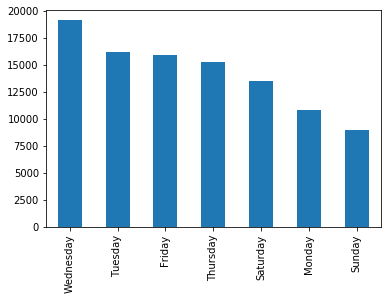

In [27]:
uber_april.date.dt.day_name().value_counts().plot(kind='bar')

## Weekday ordered chronologically

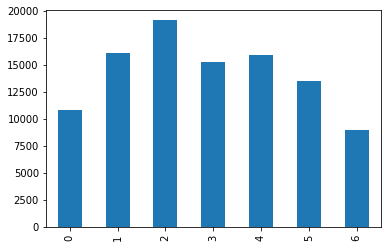

In [28]:
uber_april.date.dt.dayofweek.value_counts(sort=False).plot(kind='bar')

## <font color="red"> Exercise 1 </font>

Explore the distributions of rides by hour and minute

In [35]:
# Your code here

## Pandas specific date tricks

* Step 1 - Switch dates to indexes
* Step 2- Use Pandas timeseries tools
    * Filter by date
    * Aggregate by dates

## Moving dates to indexes using `set_index`

In [29]:
uber_april_indexed = uber_april.set_index('date')
uber_april_indexed.head()

,lat,lon,base
date,,,
2014-04-18 21:38:00,40.7359,-73.9852,B02682
2014-04-23 15:19:00,40.7642,-73.9543,B02598
2014-04-10 07:15:00,40.7138,-74.0103,B02598
2014-04-11 15:23:00,40.7847,-73.9698,B02682
2014-04-07 17:26:00,40.6460,-73.7767,B02598


## Setting indexes  - the `dfply` way

In [32]:
from more_dfply import set_index

In [33]:
uber_idx = (uber_april >>
              set_index(X.date) >>
              drop(X.date))
uber_idx.head()

,lat,lon,base
date,,,
2014-04-18 21:38:00,40.7359,-73.9852,B02682
2014-04-23 15:19:00,40.7642,-73.9543,B02598
2014-04-10 07:15:00,40.7138,-74.0103,B02598
2014-04-11 15:23:00,40.7847,-73.9698,B02682
2014-04-07 17:26:00,40.6460,-73.7767,B02598


In [34]:
uber_idx.index

DatetimeIndex(['2014-04-18 21:38:00', '2014-04-23 15:19:00',
               '2014-04-10 07:15:00', '2014-04-11 15:23:00',
               '2014-04-07 17:26:00', '2014-04-10 16:56:00',
               '2014-04-24 23:26:00', '2014-04-23 13:44:00',
               '2014-04-09 07:05:00', '2014-04-27 15:07:00',
               ...
               '2014-04-09 08:07:00', '2014-04-30 14:02:00',
               '2014-04-02 14:11:00', '2014-04-23 07:37:00',
               '2014-04-21 20:01:00', '2014-04-26 22:24:00',
               '2014-04-25 05:12:00', '2014-04-18 17:44:00',
               '2014-04-25 23:04:00', '2014-04-18 16:08:00'],
              dtype='datetime64[ns]', name='date', length=100000, freq=None)

In [35]:
uber_idx.index.day

Int64Index([18, 23, 10, 11,  7, 10, 24, 23,  9, 27,
            ...
             9, 30,  2, 23, 21, 26, 25, 18, 25, 18],
           dtype='int64', name='date', length=100000)

In [36]:
uber_idx.index.hour

Int64Index([21, 15,  7, 15, 17, 16, 23, 13,  7, 15,
            ...
             8, 14, 14,  7, 20, 22,  5, 17, 23, 16],
           dtype='int64', name='date', length=100000)

In [37]:
uber_idx.index.day_name()

Index(['Friday', 'Wednesday', 'Thursday', 'Friday', 'Monday', 'Thursday',
       'Thursday', 'Wednesday', 'Wednesday', 'Sunday',
       ...
       'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday', 'Monday',
       'Saturday', 'Friday', 'Friday', 'Friday', 'Friday'],
      dtype='object', name='date', length=100000)

## Index slicing - the `dfply` way

In [38]:
from more_dfply import row_index_slice

(uber_idx >>
   row_index_slice('2014-04-03') >>
   head)

,lat,lon,base
date,,,
2014-04-03 07:26:00,40.7345,-73.9939,B02598
2014-04-03 21:07:00,40.7534,-73.9805,B02682
2014-04-03 13:41:00,40.7411,-73.9943,B02598
2014-04-03 21:43:00,40.7288,-74.0016,B02598
2014-04-03 14:00:00,40.7565,-73.9718,B02682


In [39]:
(uber_idx >>
   row_index_slice('2014-04-03','2014-04-05') >>
   head)

,lat,lon,base
date,,,
2014-04-03 07:26:00,40.7345,-73.9939,B02598
2014-04-04 23:30:00,40.7300,-73.9992,B02598
2014-04-05 18:50:00,40.6690,-73.9860,B02598
2014-04-04 18:25:00,40.7950,-73.9697,B02598
2014-04-05 08:52:00,40.7031,-73.9422,B02682


## Row indexing with boolean expressions

In [40]:
(uber_idx >>
   row_index_slice(X.index.day == 2) >>
   head)

,lat,lon,base
date,,,
2014-04-02 21:57:00,40.7615,-73.9865,B02617
2014-04-02 15:53:00,40.7256,-74.0046,B02598
2014-04-02 18:32:00,40.7580,-73.9818,B02682
2014-04-02 07:15:00,40.7734,-73.9490,B02598
2014-04-02 09:09:00,40.7605,-73.9819,B02598


In [41]:
(uber_idx >>
   row_index_slice(X.index.day_name() == 'Monday') >>
   head)

,lat,lon,base
date,,,
2014-04-07 17:26:00,40.6460,-73.7767,B02598
2014-04-21 09:24:00,40.6904,-73.9663,B02598
2014-04-07 05:15:00,40.6848,-74.0018,B02617
2014-04-07 15:56:00,40.7143,-74.0142,B02682
2014-04-07 17:47:00,40.7554,-73.9849,B02682


## Using resample to aggregate by dateparts

* Reshape will redefine the rows
* Works with aggregation line `mean` or `count`

In [42]:
@pipe
@symbolic_evaluation(eval_symbols=[0])
def resample(df,rule,how=None,axis=0,fill_method=None,closed=None,
label=None,convention='start',kind=None,loffset=None,
limit=None,base=0,on=None,level=None):
    return df.resample(rule, how=how, axis=axis, fill_method=fill_method, 
                  closed=closed, label=label, convention=convention, 
                  kind=kind, loffset=loffset, limit=limit, base=base, 
                  on=on, level=level)

In [43]:
weekly_counts = ((uber_idx >>
                   mutate(ones = np.ones(uber_idx.shape[0])) >>
                   select(X.ones) >>
                   resample('W')).sum() >>
                 rename(counts = 'ones'))
weekly_counts

TypeError: resample() got an unexpected keyword argument 'how'

In [59]:
weekly_counts.counts.plot('bar')

NameError: name 'weekly_counts' is not defined

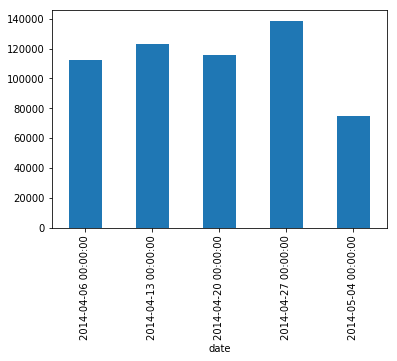

In [33]:
weekly_counts.counts.plot('bar')

## <font color="red"> Exercise 2 </font>

Explore the distributions of rides by hour, this time using the indexes to resample

In [34]:
# Your code here

## Note on writing to csv

To preserve the dates, 

* make sure you use `index=True`
* This will write the index as the first column

In [35]:
weekly_counts.to_csv('uber_april_weekly_counts.csv', index=True)

In [36]:
!cat uber_april_weekly_counts.csv

date,counts
2014-04-06,112401.0
2014-04-13,123324.0
2014-04-20,115698.0
2014-04-27,138532.0
2014-05-04,74561.0
